In [6]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import gc
from eval import *
import numpy as np

In [8]:
class DownsampleBlock(nn.Module):
    def __init__(self, num_channels, num_output_channels, kernel_size = 4, stride = 2, padding = 1, bias = False):
        super(DownsampleBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(num_channels, num_output_channels, kernel_size, stride = stride, padding = padding, bias = bias),
            nn.BatchNorm2d(num_output_channels),
            nn.LeakyReLU(),
        )
        
    def forward(self, inputs):
        return self.conv(inputs)
    
class UpsampleBlock(nn.Module):
    def __init__(self, num_channels, num_output_channels, kernel_size = 4, stride = 2, padding = 1, bias = False, **kwargs):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(num_channels, num_output_channels, kernel_size, stride = stride, padding = padding, bias = bias, **kwargs)
        )
        
    def forward(self, inputs):
        return self.conv(inputs)
    
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        self.DownsampleBlocks = nn.ModuleList([
            DownsampleBlock(3, 64, padding = 0, bias = False), #3 x 256 x 256
            DownsampleBlock(64, 128, padding = 1, bias = False), #64 x 127 x 127
            DownsampleBlock(128, 256, padding = 1, bias = False), #128 x 63 x 63
            DownsampleBlock(256, 512, padding = 1, bias = False) #256 x 31 x 31
        ]) #512 x 15 x 15
        
        self.UpsampleBlocks = nn.ModuleList([ 
            UpsampleBlock(512, 256, kernel_size = 3, padding = 0), #256 x 31 x 31 -> 512 x 31 x 31
            UpsampleBlock(512, 128, padding = 0, kernel_size = 3), #128 x 63 x 63 -> 256 x 63 x 63
            UpsampleBlock(256, 64, padding = 0, kernel_size = 3), #64 x 127 x 127 -> 128 x 127 x 127
            UpsampleBlock(128, 3, padding = 0, kernel_size = 4), #128 x 255 x 255 -> 64 x 255 x 255
            #UpsampleBlock(32, 3, padding = 0) #3 x 255 x 255
        ])
        
        self.tanh = nn.Tanh()
    
    def forward(self, inputs):
        #downsample from 32x3x256x256
        #3 CNN layers: 32 x 3 x 256 x 256 with 4 by 4 kernel
        #
        ls = [] #will contain the 64, 128, 256 and 512 layers
        for downsample_block in self.DownsampleBlocks:
            inputs = downsample_block(inputs)
            ls.append(inputs) #save the stuff for concatenating
            #print(f'downsampling: {inputs.shape}')
        ls = ls[:-1][::-1]
        
        #upsampling input is 32 x 1 x 16 x 16
        for i, upsample_block in enumerate(self.UpsampleBlocks):
            inputs = upsample_block(inputs)
            if i < len(ls):
                inputs = torch.cat((inputs, ls[i]), dim = 1) #concatenate with earlier layers
            #print(f'upsampling: {inputs.shape}')
            
        inputs = self.tanh(inputs)
        return inputs

            
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #bs x 3 x 256 x 256
            nn.Conv2d(3, 64, 4, 2, bias = False),
            #bs x 64 x 127 x 127
            nn.LeakyReLU(),
            
            nn.Conv2d(64, 128, 4, 2, padding = 1, bias = False),
            #bs x 128 x 63 x 63
            nn.LeakyReLU(),
            
            nn.Conv2d(128, 256, 4, 2, padding = 1, bias = False),
            #bs x 256 x 31 x 31
            nn.LeakyReLU(),
            
            nn.Conv2d(256, 1, 4, 1, padding = 0, bias = False)
            #bs x 1 x 28 x 28 
        )
    
    def forward(self, inputs):
        inputs = self.main(inputs)
        return inputs
    
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.photo_disc = Discriminator()
        self.monet_disc = Discriminator()
        self.photo_gen = UNetGenerator()
        self.monet_gen = UNetGenerator()
        
        self.photo_gen_optimizer = Adam(self.photo_gen.parameters(), lr = 1e-4)
        self.monet_gen_optimizer = Adam(self.monet_gen.parameters(), lr = 1e-4)
        self.photo_disc_optimizer = Adam(self.photo_disc.parameters(), lr = 1e-4)
        self.monet_disc_optimizer = Adam(self.monet_disc.parameters(), lr = 1e-4)
        
    def forward(self, data):
        photos, monets = data
        #photo -> monet -> photo
        #print(photos.shape)
        fake_monet = self.monet_gen(photos)
        
        #print('generated fake monet')
        #fake photo dimension is 
        cycled_photo = self.photo_gen(fake_monet)
        
        #print('generated cycled photo')
        #monet -> photo -> monet
        fake_photo = self.photo_gen(monets)
        
        #print('generated fake photo')
        cycled_monet = self.monet_gen(fake_photo)
        
        #print('generated cycled monet')
        #generate true with true
        pred_photo = self.photo_gen(photos)
        pred_monet = self.monet_gen(monets)
        
        #train discriminators
        #photo discriminator
        #put real first
        real_disc_photo = self.photo_disc(photos)
        real_disc_monet = self.monet_disc(monets)
        
        #then put fakes
        fake_disc_photo = self.photo_disc(fake_photo)
        fake_disc_monet = self.monet_disc(fake_monet)
        
        #print(f'cycled_photo shape: {cycled_photo.shape}')

        return cycled_photo, cycled_monet, pred_photo, pred_monet, real_disc_photo, real_disc_monet, fake_disc_photo, fake_disc_monet
    
        

In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0, 0.02)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)

In [10]:
#H_out =(H_in−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
#(127-1) * 2 - 2*0 + 1*(4-1) + 0 + 1

In [11]:
gc.collect()

0

In [12]:
#write training loop
monet_dataset = dset.ImageFolder('../data/monet', transform = transforms.Compose([transforms.ToTensor()]))
monet_dataloader = DataLoader(monet_dataset, batch_size = 10, shuffle = True)

photo_dataset = dset.ImageFolder('../data/photo', transform = transforms.Compose([transforms.ToTensor()]))
photo_dataloader = DataLoader(photo_dataset, batch_size = 10, shuffle = True)

device = torch.device('cuda:0')


In [13]:
#to have a CycleGAN perform well, it needs to be able to:
"""
1. discriminate
2. generate
"""
#cycle_loss
def cycle_loss_func(initial_photo, regen_photo, initial_monet, regen_monet):
    #initial, regenerated image
    return torch.mean(torch.abs(regen_photo - initial_photo)) + torch.mean(torch.abs(regen_monet - initial_monet))

#
def true_disc_loss_func(true_img): #true for discriminator
    #the disc photo needs to predict 1 if input image is a photo (conversely, monet)
    #need to minimize MSE(disc_img, 1)
    #now it will make MSE 0 by making disc_img close to 1
    #true_img.to(device)
    return true_img.sub(1).pow(2).mean()*0.5

#
def fake_disc_loss_func(fake_img): #if discriminator sees fake images then try to get a 0.
    
    return fake_img.pow(2).mean()*0.5

def true_gen_loss(disc_gen_img): #true for generator
    #if discriminator takes in a generated photo and the discriminator predicts a true
    #try to get generated images through

    return disc_gen_img.sub(1).pow(2).mean()

def identity_loss(true_img, gen_true_img): #if photos go through photo (monet) generator it must return photo (monet)
    return gen_true_img.sub(true_img).pow(2).mean()*0.5


In [17]:
#training loop
w = 10 #weight the cycle loss higher
epochs = 50

#create models
model = CycleGAN()
model.to(device)
model.apply(weights_init)

losses = {'disc_photo': [],
         'disc_monet': [],
         'gen_photo': [],
         'gen_monet': []}

for epoch in range(epochs):
    running_loss = {'disc_photo': 0,
         'disc_monet': 0,
         'gen_photo': 0,
         'gen_monet': 0}
    for i, data in enumerate(zip(photo_dataloader, monet_dataloader)):
        
        model.photo_gen_optimizer.zero_grad()
        model.monet_gen_optimizer.zero_grad()
        model.photo_disc_optimizer.zero_grad()
        model.monet_disc_optimizer.zero_grad()
        
        data = [data[i][0] for i in range(len(data))]
        
        photos = data[0].to(device)
        monets = data[1].to(device)
        
        cycled_photo, cycled_monet, pred_photo, pred_monet, real_disc_photo, real_disc_monet, fake_disc_photo, fake_disc_monet = model((photos, monets))
        
        del data
        
        #photos.to(device)
        #monets.to(device)
        cycled_photo.to(device)
        cycled_monet.to(device)
        
        total_cycle_loss = cycle_loss_func(photos, cycled_photo, monets, cycled_monet).cpu()
        
        del cycled_photo, cycled_monet
        
        pred_monet.to(device)
        pred_photo.to(device)
        
        i_photo = identity_loss(photos, pred_photo).cpu()
        i_monet = identity_loss(monets, pred_monet).cpu()
        
        del pred_photo, pred_monet, photos, monets
        
        real_disc_photo.to(device)
        real_disc_monet.to(device)
        fake_disc_photo.to(device)
        fake_disc_monet.to(device)
        
        loss_photo_disc = fake_disc_loss_func(fake_disc_photo) + true_disc_loss_func(real_disc_photo)
        loss_monet_disc = fake_disc_loss_func(fake_disc_monet) + true_disc_loss_func(real_disc_monet)
        
        del real_disc_photo, real_disc_monet
        
        loss_photo_disc.backward(retain_graph=True)
        loss_monet_disc.backward(retain_graph=True)
        model.photo_disc_optimizer.step()
        model.monet_disc_optimizer.step()
        
        loss_photo_gen = w*total_cycle_loss + true_gen_loss(fake_disc_photo).cpu() + i_photo
        loss_monet_gen = w*total_cycle_loss + true_gen_loss(fake_disc_monet).cpu() + i_monet
        
        del fake_disc_photo, fake_disc_monet
        
        loss_photo_gen.backward(retain_graph=True)
        loss_monet_gen.backward()
        
        model.photo_gen_optimizer.step()
        model.monet_gen_optimizer.step()
        
        running_loss['disc_photo'] += loss_photo_disc.item()
        running_loss['disc_monet'] += loss_monet_disc.item()
        running_loss['gen_photo'] += loss_photo_gen.item()
        running_loss['gen_monet'] += loss_monet_gen.item()
        
    a = running_loss['disc_photo']/i #num_batches
    b = running_loss['disc_monet']/i
    c = running_loss['gen_photo']/i
    d = running_loss['gen_monet']/i
    
    losses['disc_photo'].append(a)
    losses['disc_monet'].append(b)
    losses['gen_photo'].append(c)
    losses['gen_monet'].append(d)

    print('epoch {} completed'.format(epoch+1))
    print(f'Photo Discriminator Loss: {a}\
          Monet Discriminator Loss: {b}\
         Photo Generator Loss: {c}\
         Monet Generator Loss: {d}')

epoch 1 completed
Photo Discriminator Loss: 0.35002878667979404          Monet Discriminator Loss: 0.33097259032315224         Photo Generator Loss: 5.299608945846558         Monet Generator Loss: 5.31048504237471
epoch 2 completed
Photo Discriminator Loss: 0.2865535560353049          Monet Discriminator Loss: 0.28629420543539114         Photo Generator Loss: 2.497196707232245         Monet Generator Loss: 2.4766949826273423
epoch 3 completed
Photo Discriminator Loss: 0.2590309366069991          Monet Discriminator Loss: 0.24524997791339612         Photo Generator Loss: 2.2874408138209374         Monet Generator Loss: 2.279003077539904
epoch 4 completed
Photo Discriminator Loss: 0.23852081134401518          Monet Discriminator Loss: 0.22529403916720686         Photo Generator Loss: 2.3066363416869065         Monet Generator Loss: 2.295057485843527
epoch 5 completed
Photo Discriminator Loss: 0.3050081570600641          Monet Discriminator Loss: 0.287490647414635         Photo Generator 

epoch 39 completed
Photo Discriminator Loss: 0.22186942604081383          Monet Discriminator Loss: 0.2552662183498514         Photo Generator Loss: 1.6514746320658718         Monet Generator Loss: 1.539346407199728
epoch 40 completed
Photo Discriminator Loss: 0.23740730049281283          Monet Discriminator Loss: 0.23057499322397956         Photo Generator Loss: 1.642554340691402         Monet Generator Loss: 1.5410170102941578
epoch 41 completed
Photo Discriminator Loss: 0.2399175120838757          Monet Discriminator Loss: 0.2198026586195518         Photo Generator Loss: 1.647147824024332         Monet Generator Loss: 1.5645044137691628
epoch 42 completed
Photo Discriminator Loss: 0.22336159081294618          Monet Discriminator Loss: 0.23536241773901315         Photo Generator Loss: 1.6275675995596524         Monet Generator Loss: 1.542641516389518
epoch 43 completed
Photo Discriminator Loss: 0.21608223123797055          Monet Discriminator Loss: 0.24637386665262026         Photo G

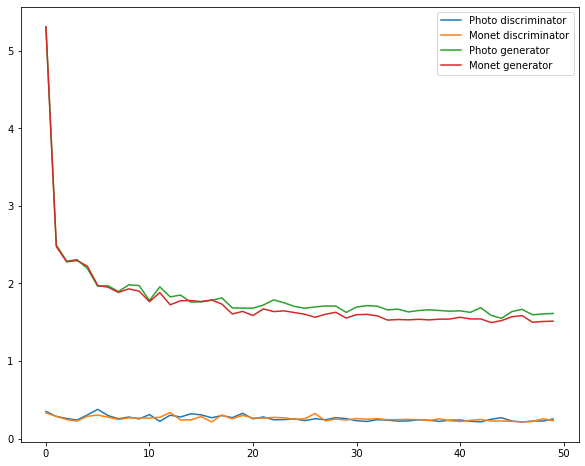

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
plt.plot(losses['disc_photo'], label = 'Photo discriminator')
plt.plot(losses['disc_monet'], label = 'Monet discriminator')
plt.plot(losses['gen_photo'], label = 'Photo generator')
plt.plot(losses['gen_monet'], label = 'Monet generator')
plt.legend()
plt.show()

In [19]:
model.to('cpu')
model.eval()

CycleGAN(
  (photo_disc): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
  )
  (monet_disc): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(256, 1, kernel_size=(

In [21]:
model.monet_gen.eval()

UNetGenerator(
  (DownsampleBlocks): ModuleList(
    (0): DownsampleBlock(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): DownsampleBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): DownsampleBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): DownsampleBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512,

In [25]:
original = next(iter(photo_dataloader))[0]
result = model.monet_gen(original).cpu().detach()

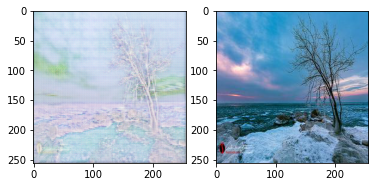

In [26]:
fig, ax = plt.subplots(1,2)
ax[0].imshow((result[0].permute(1,2,0)*127.5 + 127.5).numpy().astype(np.uint8))
ax[1].imshow(original[0].permute(1,2,0).numpy())

In [4]:
v3 = torch.load('inceptionv3.pkl')

In [5]:
v3.eval()

InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

In [16]:
original.shape

torch.Size([10, 3, 256, 256])

In [28]:
o = v3(original)
r = v3(result)

In [29]:
o[0].shape

torch.Size([10, 2048, 1, 1])

In [55]:
def calculate_FID_distance(A, B):
    mu_A = np.mean(A, axis = 0)
    mu_B = np.mean(B, axis = 0)
    cov_A = np.cov(A, rowvar=False)
    cov_B = np.cov(B, rowvar = False)
    covmean = scipy.linalg.sqrtm(cov_A.dot(cov_B))
    ssq = np.sum(np.square(mu_A-mu_B))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    return ssq + np.trace(cov_A+cov_B-2*covmean)

In [61]:
def calculate_d_ij(real_vec, gen_vec):
    return 1 - np.dot(real_vec, gen_vec)/(np.linalg.norm(real_vec)*np.linalg.norm(gen_vec))

def calculate_memorization(gen_matrix, real_matrix, eps):
    #dimension of real: M*2048, gen: N*2048
    #final score matrix: N*M (gen by real)
    score = np.zeros((gen_matrix.shape[0], real_matrix.shape[0]))
    #e.g 3 by 2048
    for i in range(gen_matrix.shape[0]):
        for j in range(real_matrix.shape[0]):
            score[i,j] = calculate_d_ij(real_matrix[j,:], gen_matrix[i,:])

    #average all the generated images
    d = np.mean(np.min(score, axis=0))
    if d < eps:
        dthr = d
    else:
        dthr = 1
    
    return dthr

In [66]:
def get_mifid(gen_matrix, real_matrix, eps = 1e-15):
    d = calculate_FID_distance(gen_matrix, real_matrix)
    mem = calculate_memorization(gen_matrix, real_matrix, eps)
    return d/mem


In [67]:
get_mifid(o[0].squeeze().numpy(), r[0].squeeze().numpy())

[[0.53056085 0.50694934 0.4776966  0.51904967 0.56143132 0.63911399
  0.55009636 0.54638043 0.52530131 0.50612429]
 [0.58118337 0.57022223 0.54906014 0.51932153 0.60853082 0.68058324
  0.609916   0.57730246 0.5462701  0.5727199 ]
 [0.46520197 0.44165564 0.24051905 0.37762803 0.55303574 0.6076842
  0.49994177 0.50787991 0.44655561 0.42166364]
 [0.50732741 0.46870685 0.40732777 0.43289441 0.5592345  0.63764668
  0.52582473 0.55775136 0.46738946 0.45220393]
 [0.51008055 0.48124456 0.45811123 0.47885805 0.5382401  0.63854781
  0.52786613 0.53669268 0.49683547 0.47390246]
 [0.46078503 0.4667173  0.49039096 0.50209212 0.52082887 0.50507537
  0.54397246 0.43770337 0.54615501 0.49417335]
 [0.57583186 0.5637818  0.51061153 0.54950362 0.59670961 0.63630277
  0.59072879 0.61066538 0.56593144 0.54312539]
 [0.543731   0.52154973 0.48675531 0.52147463 0.55800828 0.68530163
  0.55656749 0.53040963 0.47982454 0.43641126]
 [0.52105731 0.49730724 0.43219495 0.45610166 0.55336776 0.65605706
  0.55786234 

322.6853684273432

In [63]:
calculate_memorization(o[0].squeeze().numpy(), r[0].squeeze().numpy(), 0.1)

[[0.53056085 0.50694934 0.4776966  0.51904967 0.56143132 0.63911399
  0.55009636 0.54638043 0.52530131 0.50612429]
 [0.58118337 0.57022223 0.54906014 0.51932153 0.60853082 0.68058324
  0.609916   0.57730246 0.5462701  0.5727199 ]
 [0.46520197 0.44165564 0.24051905 0.37762803 0.55303574 0.6076842
  0.49994177 0.50787991 0.44655561 0.42166364]
 [0.50732741 0.46870685 0.40732777 0.43289441 0.5592345  0.63764668
  0.52582473 0.55775136 0.46738946 0.45220393]
 [0.51008055 0.48124456 0.45811123 0.47885805 0.5382401  0.63854781
  0.52786613 0.53669268 0.49683547 0.47390246]
 [0.46078503 0.4667173  0.49039096 0.50209212 0.52082887 0.50507537
  0.54397246 0.43770337 0.54615501 0.49417335]
 [0.57583186 0.5637818  0.51061153 0.54950362 0.59670961 0.63630277
  0.59072879 0.61066538 0.56593144 0.54312539]
 [0.543731   0.52154973 0.48675531 0.52147463 0.55800828 0.68530163
  0.55656749 0.53040963 0.47982454 0.43641126]
 [0.52105731 0.49730724 0.43219495 0.45610166 0.55336776 0.65605706
  0.55786234 

1